In [33]:
# Import Required Packages
import torch
import os
import json
import sys
import re
import random
import importlib.util
from typing import *
from tqdm import tqdm 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from JS_functions import *
from JS_Augmentaters import *
from seeds import *

In [34]:
import numpy as np

def plot_arc_input_outputs(input_outputs, column_headings=None, figsize_multiplier=2, show_grid=False, title_fontsize=8):
    """
    A more compact version of the plot function.
    
    Parameters:
    - input_outputs: List of lists where each element is either a 2D numpy array or (2D_array, mask).
    - column_headings: Optional list of column headings.
    - figsize_multiplier: Scale down the figure size. Default 2 means smaller than original 5.
    - show_grid: Whether to show grid lines. Default False for a cleaner, smaller plot.
    - title_fontsize: Font size for titles.
    """
    column_headings = column_headings or ["input", "output"]
    n_pairs = len(input_outputs)
    n_cols = len(input_outputs[0])

    # Create a smaller figure
    figure, axs = plt.subplots(n_pairs, n_cols, figsize=(figsize_multiplier * n_cols, figsize_multiplier * n_pairs), dpi=100)

    # Ensure axs is always 2D
    if n_pairs == 1 and n_cols == 1:
        axs = np.array([[axs]])
    elif n_pairs == 1:
        axs = axs[np.newaxis, :]
    elif n_cols == 1:
        axs = axs[:, np.newaxis]

    # Define colors
    colors_rgb = {
        0: (0x00, 0x00, 0x00),
        1: (0x00, 0x74, 0xD9),
        2: (0xFF, 0x41, 0x36),
        3: (0x2E, 0xCC, 0x40),
        4: (0xFF, 0xDC, 0x00),
        5: (0xA0, 0xA0, 0xA0),
        6: (0xF0, 0x12, 0xBE),
        7: (0xFF, 0x85, 0x1B),
        8: (0x7F, 0xDB, 0xFF),
        9: (0x87, 0x0C, 0x25),
        10: (0xFF, 0xFF, 0xFF)
    }

    _float_colors = [tuple(c / 255 for c in col) for col in colors_rgb.values()]
    arc_cmap = ListedColormap(_float_colors)

    for ex, input_output in enumerate(input_outputs):
        for col, grid in enumerate(input_output):
            ax = axs[ex, col]

            # Handle partial output case
            extra_title = ""
            if isinstance(grid, tuple) and len(grid) == 2 and isinstance(grid[0], np.ndarray):
                grid, mask = grid
                grid = grid.copy()
                if isinstance(mask, np.ndarray):
                    grid[~mask] = 10
                else:
                    grid[grid==mask] = 10
                extra_title = " partial output"
            elif not isinstance(grid, np.ndarray):
                # If it's not a numpy array or tuple as expected, skip
                continue

            grid = grid.T

            # Use pcolormesh to plot
            ax.pcolormesh(
                grid,
                cmap=arc_cmap,
                rasterized=True,
                vmin=0,
                vmax=10,
            )
            
            # Optionally show grid and ticks
            if show_grid:
                ax.set_xticks(np.arange(0, grid.shape[1]+1, 1))
                ax.set_yticks(np.arange(0, grid.shape[0]+1, 1))
                ax.grid(True, which='both')
            else:
                ax.set_xticks([])
                ax.set_yticks([])
                ax.grid(False)

            ax.set_aspect('equal')
            ax.invert_yaxis()

            if col < len(column_headings):
                ax.set_title(column_headings[col] + extra_title, fontsize=title_fontsize)
            else:
                ax.set_title(extra_title, fontsize=title_fontsize)

    plt.tight_layout()
    plt.show()


In [35]:
def concept_arc(directory_path):
    problems = []

    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)

        # Make sure it's a directory before proceeding
        if os.path.isdir(file_path):
            subproblems = [str(filename)]
            print(f"Processing: {file_path}")

            for examples in os.listdir(file_path):
                if examples.endswith(".json"):
                    full_path = os.path.join(file_path, examples)

                    with open(full_path, "r") as f:
                        problem_data = json.load(f)
                        subproblems.append(problem_data)  # Append problem_data here

            problems.append(subproblems)  # Append subproblems to problems

    return problems

# Call the function
problems = concept_arc("ConceptARC")
print(f"Total problem sets loaded: {len(problems)}")

Processing: ConceptARC/InsideOutside
Processing: ConceptARC/TopBottom3D
Processing: ConceptARC/CleanUp
Processing: ConceptARC/AboveBelow
Processing: ConceptARC/HorizontalVertical
Processing: ConceptARC/TopBottom2D
Processing: ConceptARC/SameDifferent
Processing: ConceptARC/Count
Processing: ConceptARC/Copy
Processing: ConceptARC/ExtractObjects
Processing: ConceptARC/ExtendToBoundary
Processing: ConceptARC/Order
Processing: ConceptARC/CompleteShape
Processing: ConceptARC/Center
Processing: ConceptARC/FilledNotFilled
Processing: ConceptARC/MoveToBoundary
Total problem sets loaded: 16


# Summary 

We hypothese:

$$
\text{Logic functions: } \phi_T \approx \text{Concepts/Categories}.
$$

## Observations

- 16 Concepts.
- What can a concept represent is extremly diverse as exhibited by the following examples.


### We would like to check invariances 

- Rotation 
- Flips 
- Color Changes

- Mirror
- Padding 
- Upscale

### Core knowledge

All rely on the notion of object

- Objectedness
- Goal-directness
- Numbers, Counting
- Basic Geometry, Topology

### Remark: Needed

Figure-Ground Perception: The ability to distinguish an object (figure) from its background or surrounding objects.
Counting, we can always have y that represent counting

### Conclusions

Stabilities with 

- Rotations
- flips 
- upscale 
- padding 
- color (keep track background and it is a permutation subset)

# Concepts 

### InsideOutside: Containment perception

- Cores: Object, Counting, Goal-directness
- Label: Containment Perception. 
- Description: Containment Perception, Spatial Inclusion, Enclosure Relationship. 
- Invariance: rot, color (not background nor objects within each other), flips, upscale, padding
- H: Too abstract to switch between sets

### Topbottom: Depth perception

- Cores: Object 
- Label: Spatial awarness/percpetion
- Description: Depth Perception, Spatial Relationships, Relative Position
- Invariance: rot, color (not background nor the objects within each other), flips, upscale, padding
- H: Too abstract to switch between sets

### Cleanup: Noise percepetion (Not exactly a percepetion)

- Cores: Object, Topology
- Label: Noise percpetion
- Invariance: rot, color (not background nor objects within each other), flips, upscale, padding, add noise if its another color
- H: Too abstract to switch between sets

### AboveBelow: Differentiation perception

- Cores: Object, Goal Directedness, Geometry
- Label: 
- Invariance: rot, color (not background nor objects within each other), flips, upscale, padding, add noise if its another color
- H: Too abstract to switch between sets

### HorizontalVertical: (Spatial) orientation perception

- Cores: Object, Goal Directedness, Geometry
- Label:  Spatial Orientation, Relational Perception

### TopBottom2D: (Spatial) ordinal perception


### Same Different: Similarity percepetion

### Count: Quantitative perception

### Copy: Pattern perception

### ExtractObjects: Figure-Ground perception

### ExtendToBoundary: Continuity perception

### Order: Comparative perception

### CompleteShape: Closure perception

### Center: Centroid perception

### FilledNotFilled: Completness perception

### MoveToBoundary: Motion perception

I feel like:

Order and AboveBelow are similar: Compartive and differentiation perception

ExtendToBoundary and Completeshape: continuity and closure perception

FilledNotFilled and Extractobjects: figure-ground and completness perception

In [36]:
categories = [
  "InsideOutside",
  "Topbottom",
  "Cleanup",
  "AboveBelow",
  "HorizontalVertical",
  "TopBottom2D",
  "SameDifferent",
  "Count",
  "Copy",
  "ExtractObjects",
  "ExtendToBoundary",
  "Order",
  "CompleteShape",
  "Center",
  "FilledNotFilled",
  "MoveToBoundary"
]

categories_0 = [
  "Containment",
  "Depth",
  "Noise",
  "Differentiation",
  "Spatial Orientation",
  "Spatial Ordinal",
  "Similarity",
  "Quantitative",
  "Pattern",
  "Figure-Ground",
  "Continuity",
  "Comparative",
  "Closure",
  "Centroid",
  "Completeness",
  "Motion"
]


InsideOutside
set 0


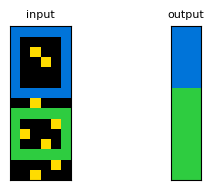

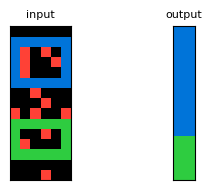

set 1


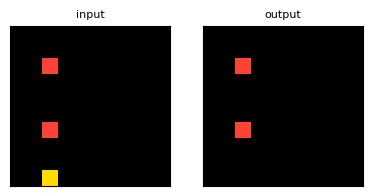

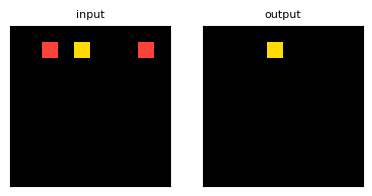

set 2


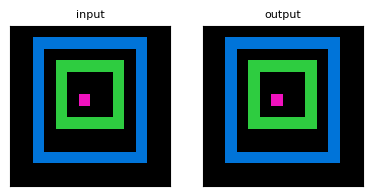

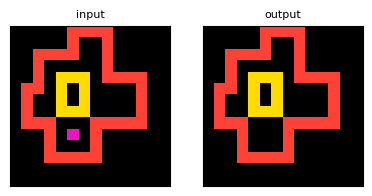

set 3


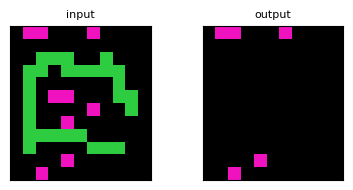

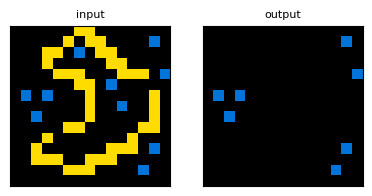

set 4


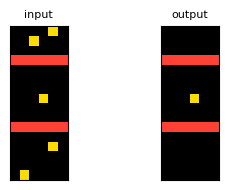

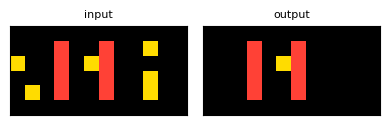

set 5


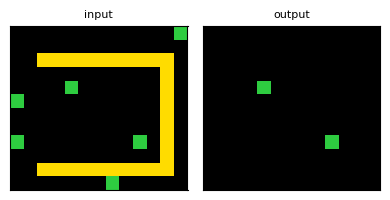

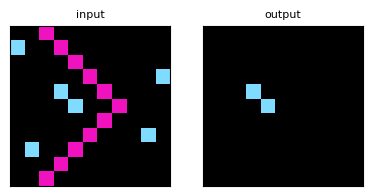

set 6


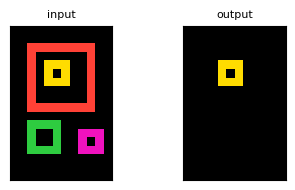

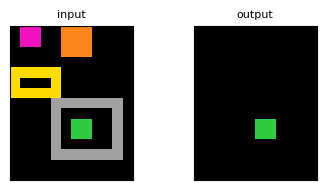

set 7


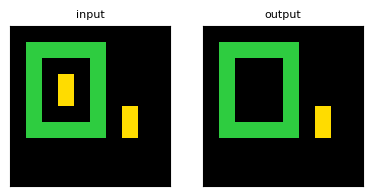

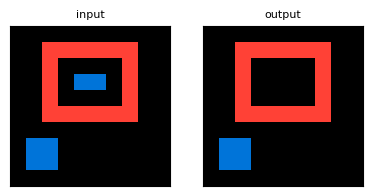

set 8


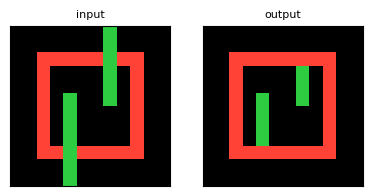

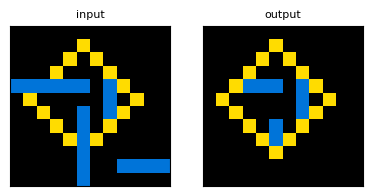

set 9


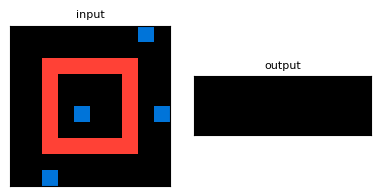

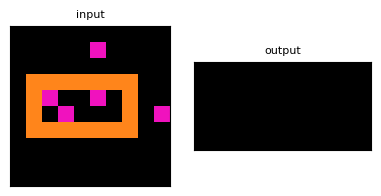

set 10


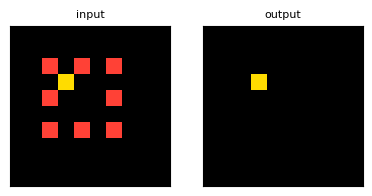

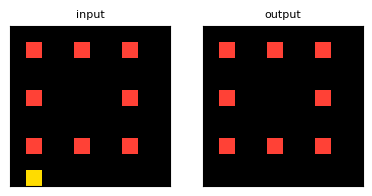

TopBottom3D
set 0


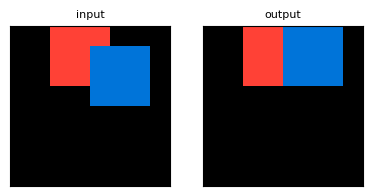

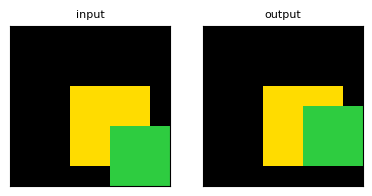

set 1


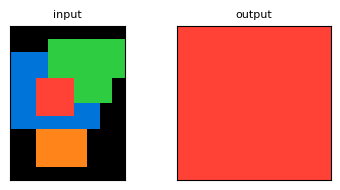

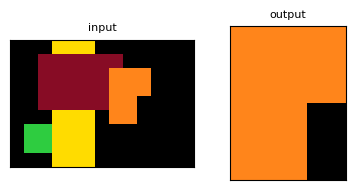

set 2


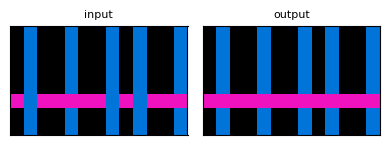

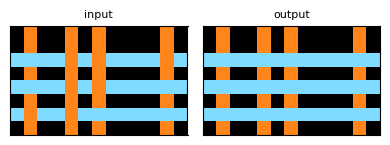

set 3


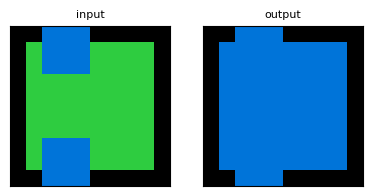

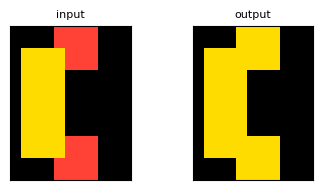

set 4


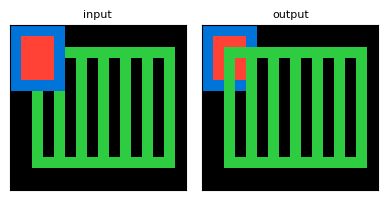

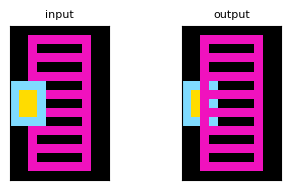

set 5


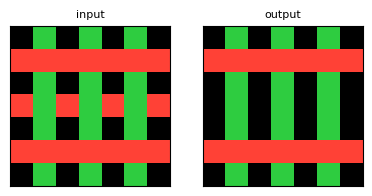

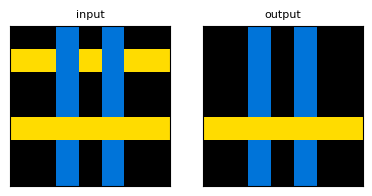

set 6


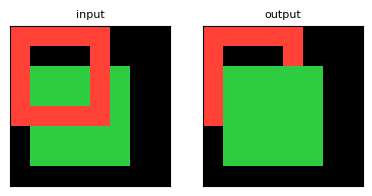

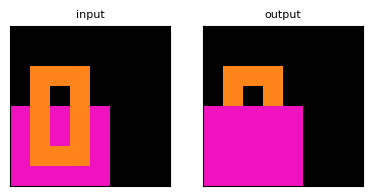

set 7


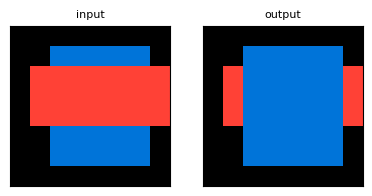

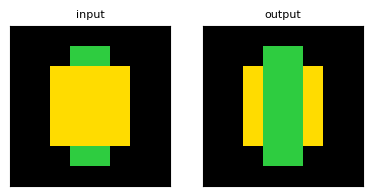

set 8


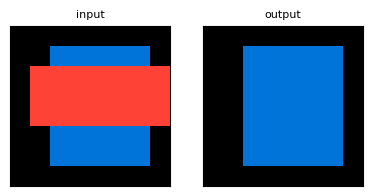

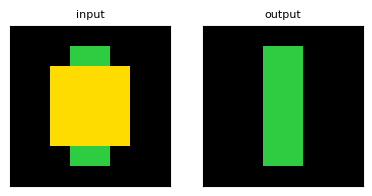

set 9


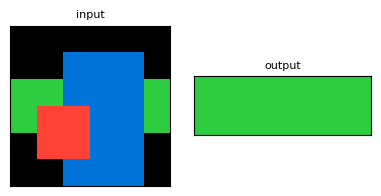

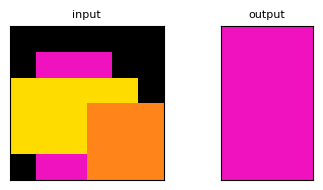

set 10


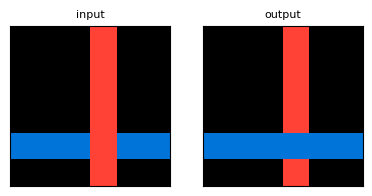

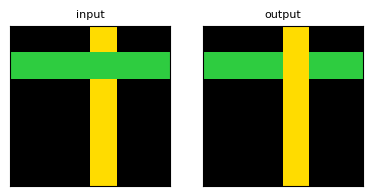

CleanUp
set 0


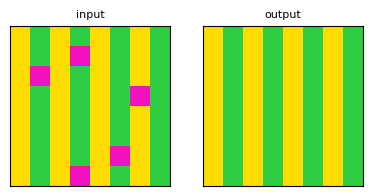

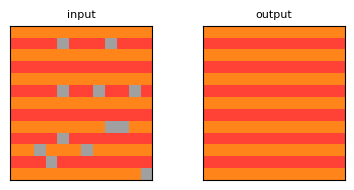

set 1


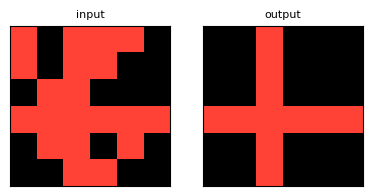

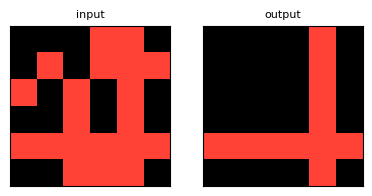

set 2


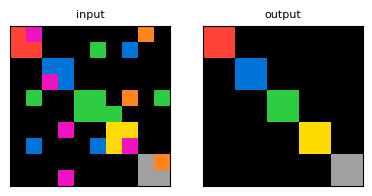

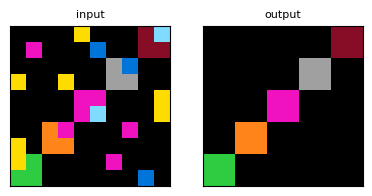

set 3


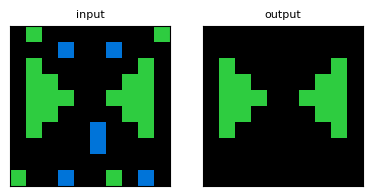

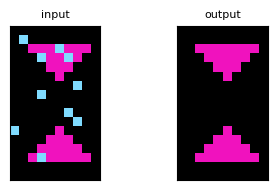

set 4


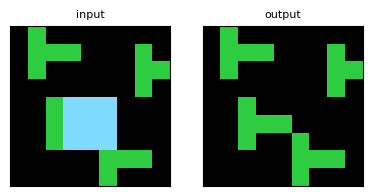

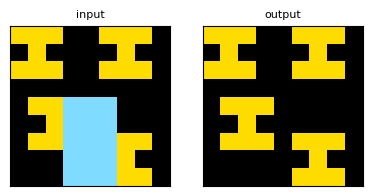

set 5


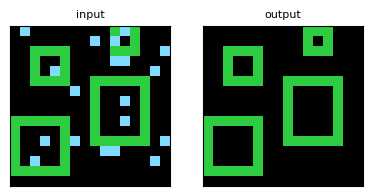

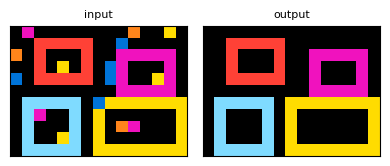

set 6


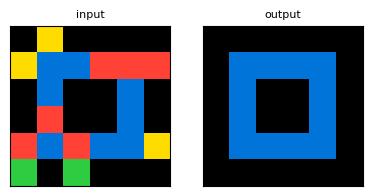

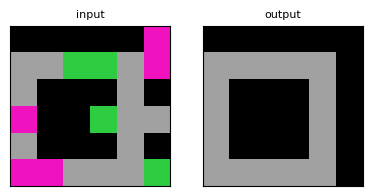

set 7


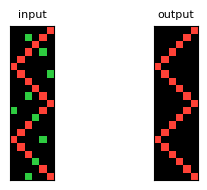

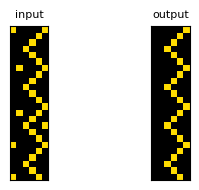

set 8


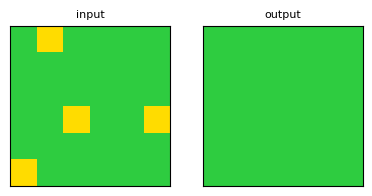

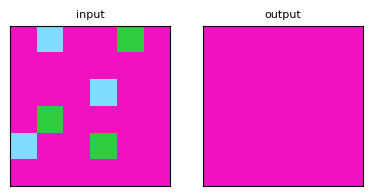

set 9


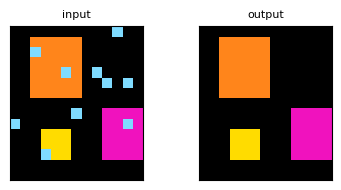

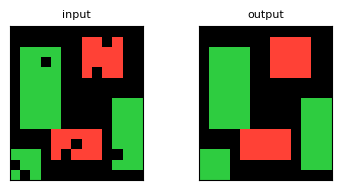

set 10


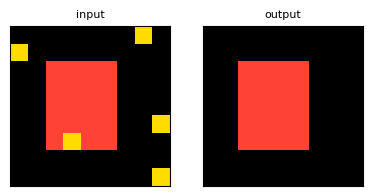

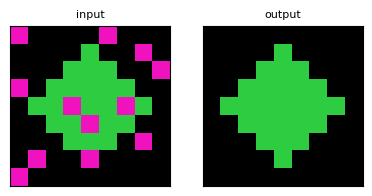

AboveBelow
set 0


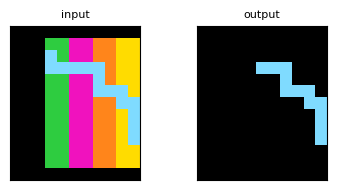

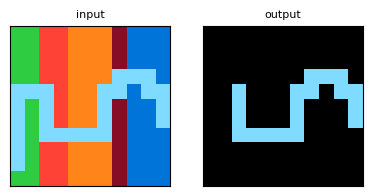

set 1


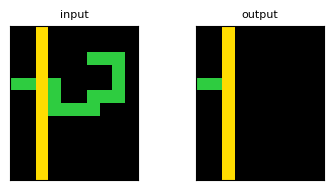

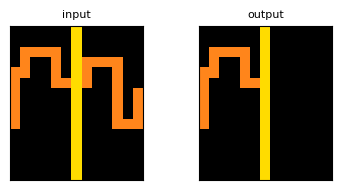

set 2


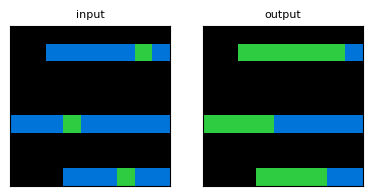

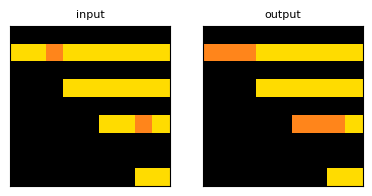

set 3


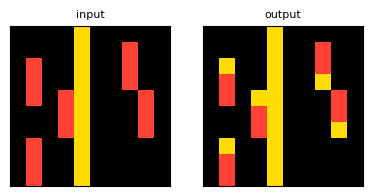

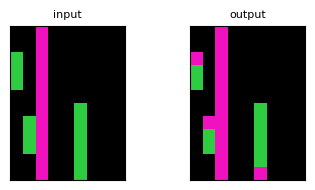

set 4


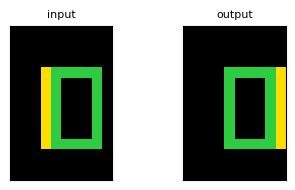

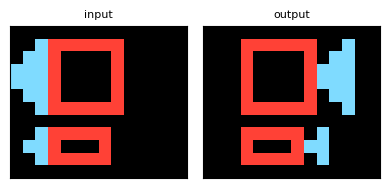

set 5


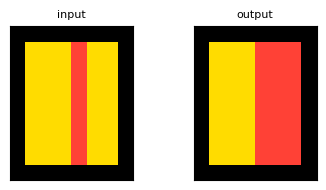

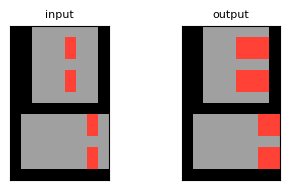

set 6


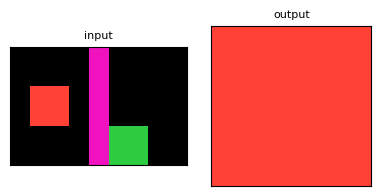

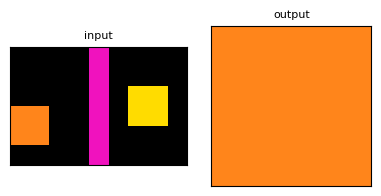

set 7


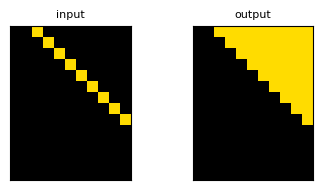

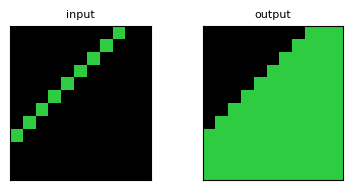

set 8


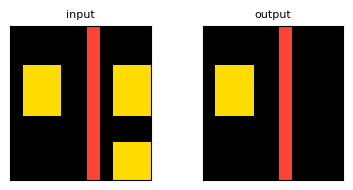

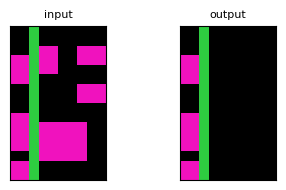

set 9


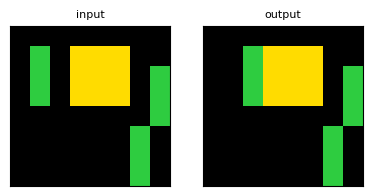

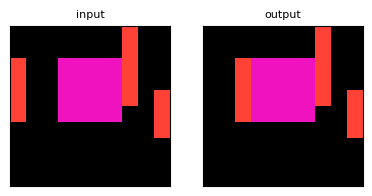

set 10


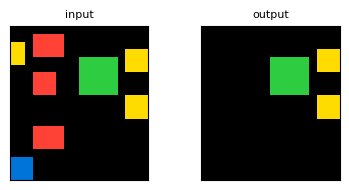

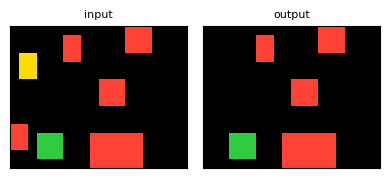

HorizontalVertical
set 0


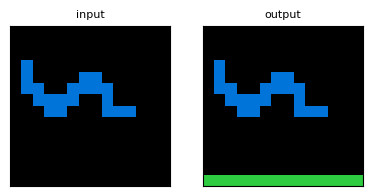

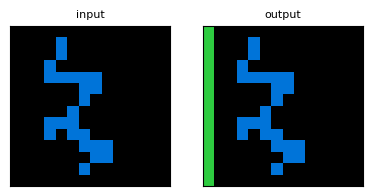

set 1


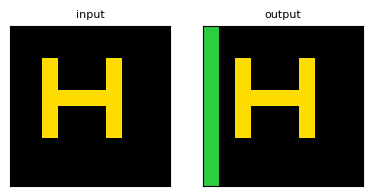

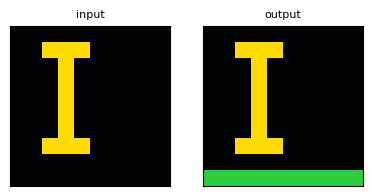

set 2


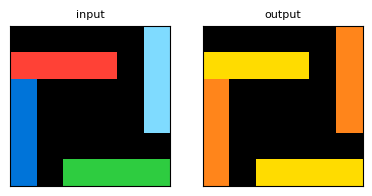

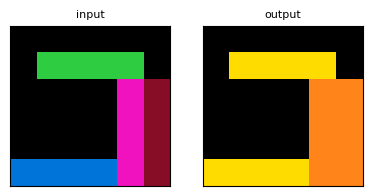

set 3


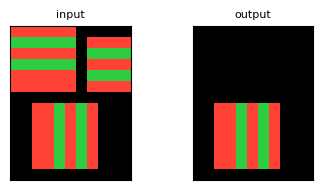

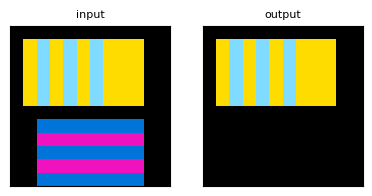

set 4


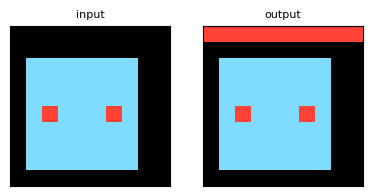

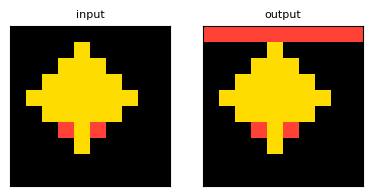

set 5


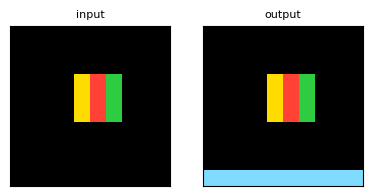

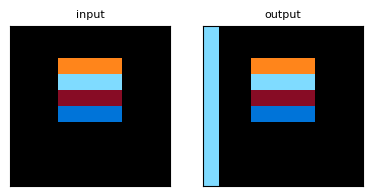

set 6


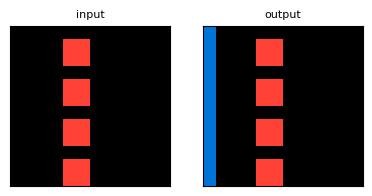

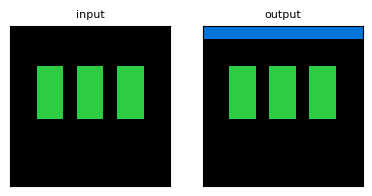

set 7


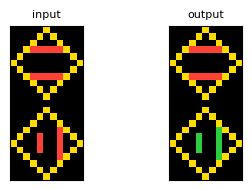

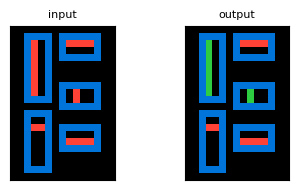

set 8


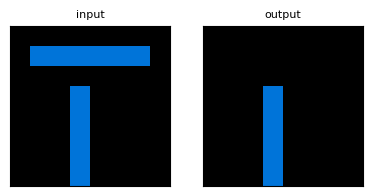

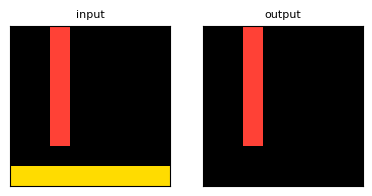

set 9


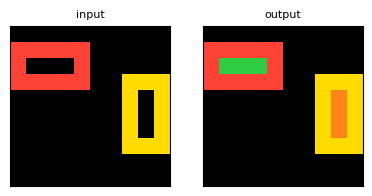

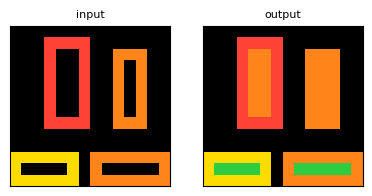

set 10


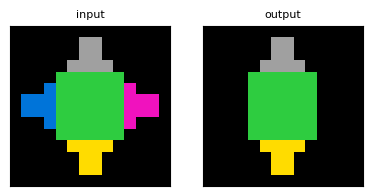

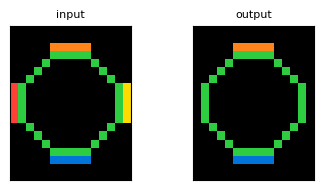

TopBottom2D
set 0


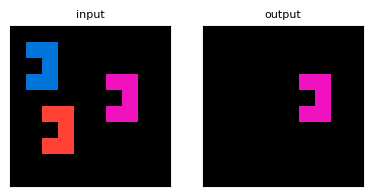

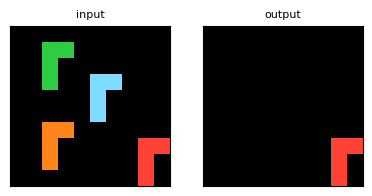

set 1


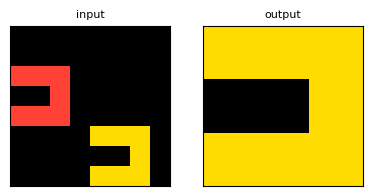

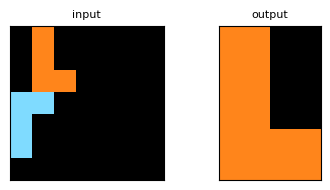

set 2


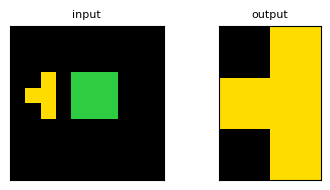

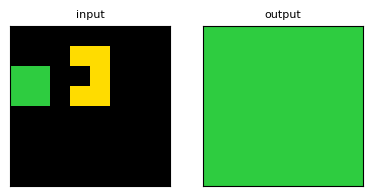

set 3


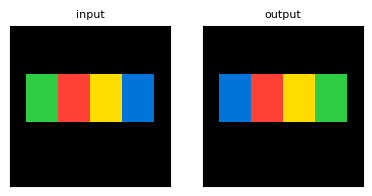

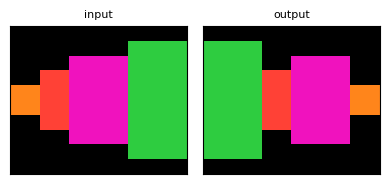

set 4


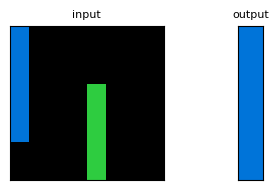

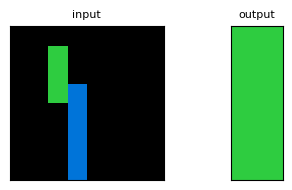

set 5


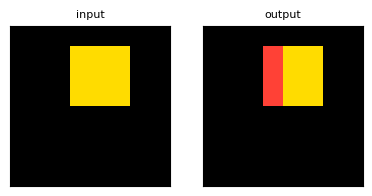

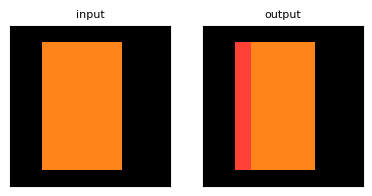

set 6


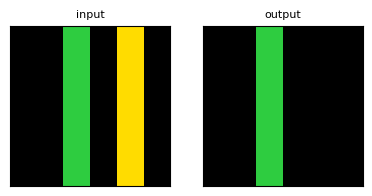

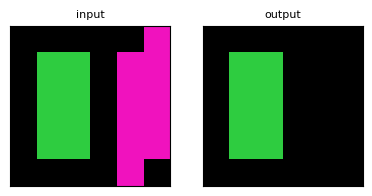

set 7


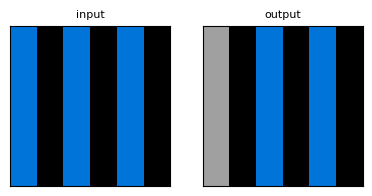

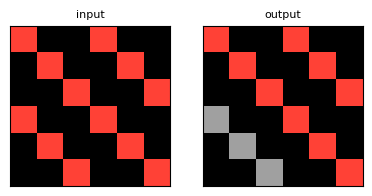

set 8


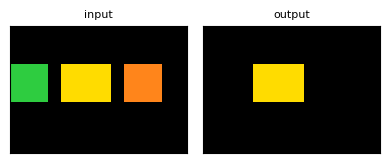

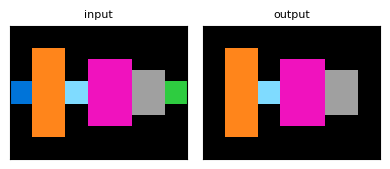

set 9


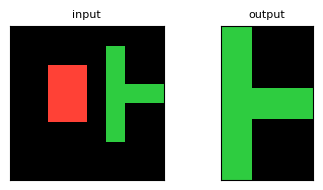

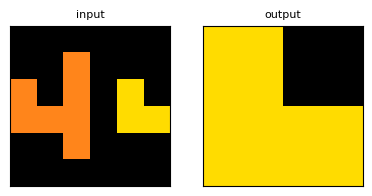

set 10


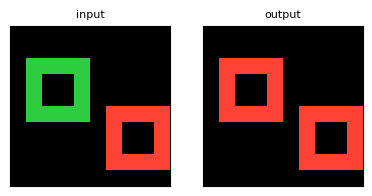

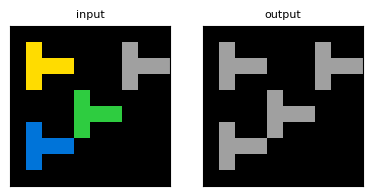

SameDifferent
set 0


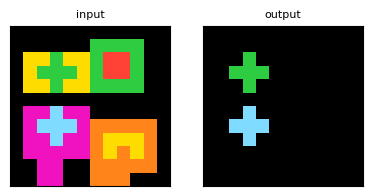

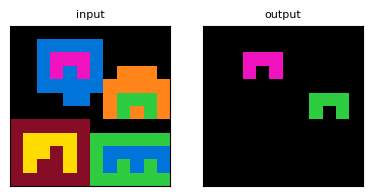

set 1


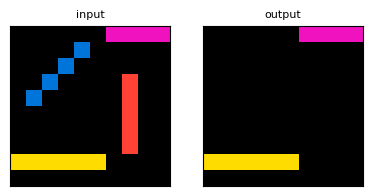

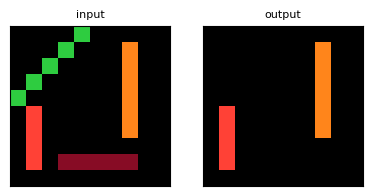

set 2


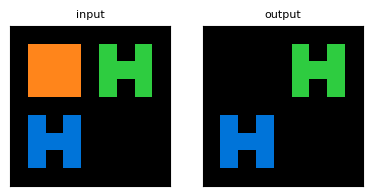

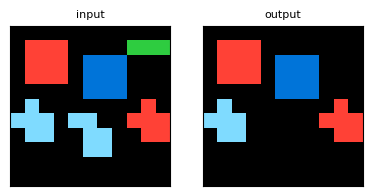

set 3


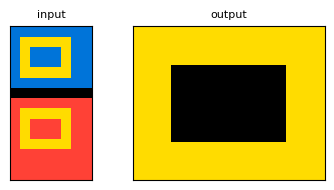

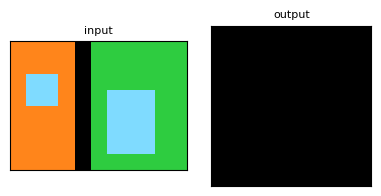

set 4


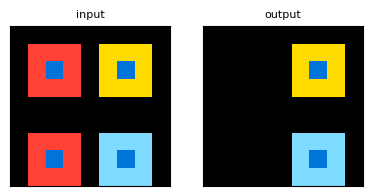

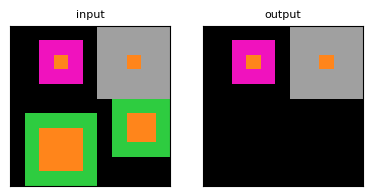

set 5


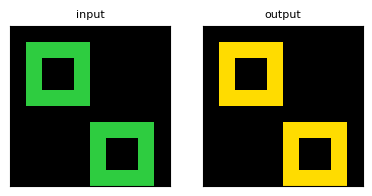

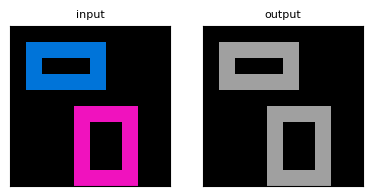

set 6


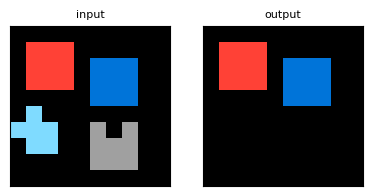

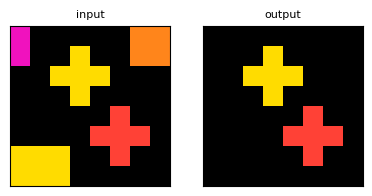

set 7


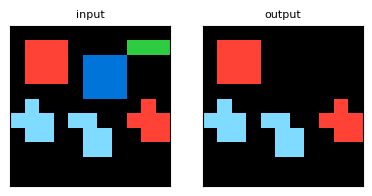

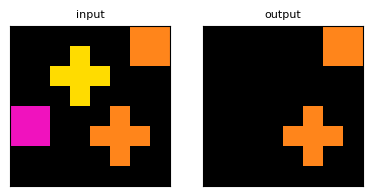

set 8


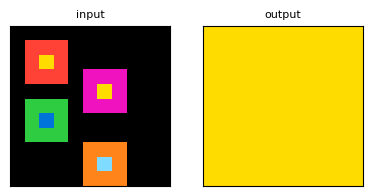

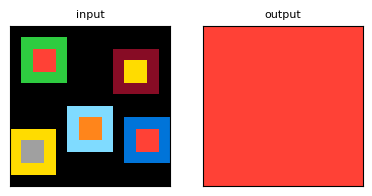

set 9


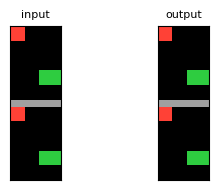

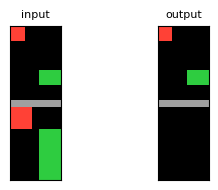

set 10


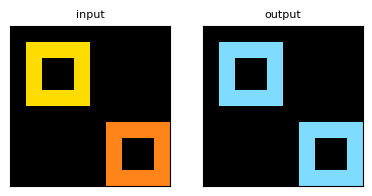

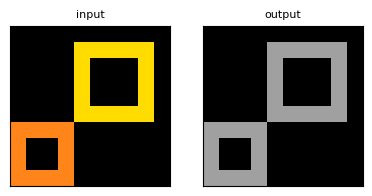

Count
set 0


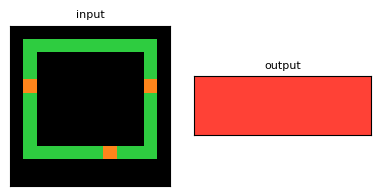

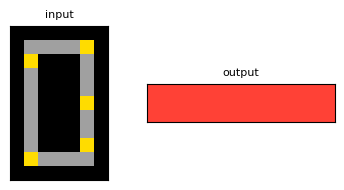

set 1


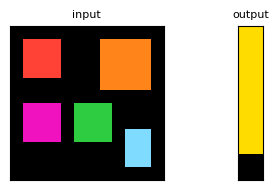

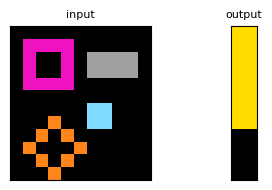

set 2


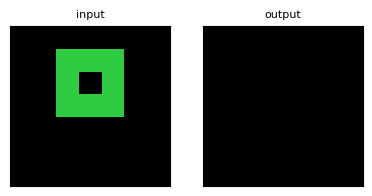

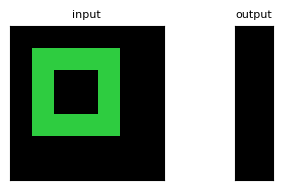

set 3


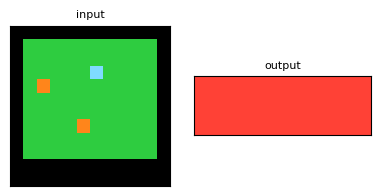

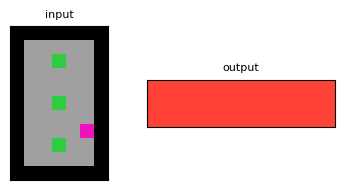

set 4


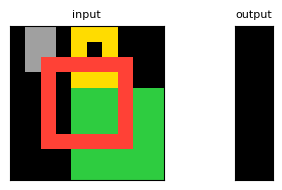

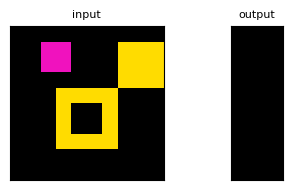

set 5


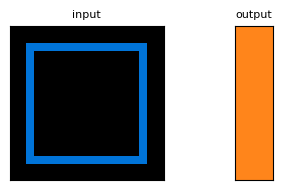

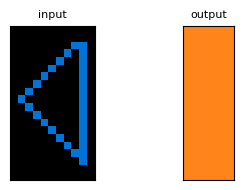

set 6


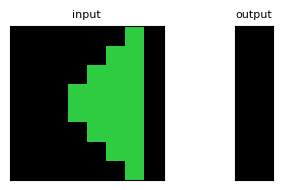

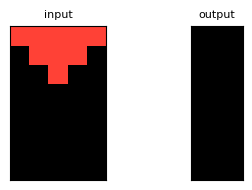

set 7


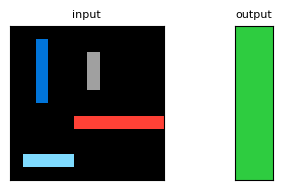

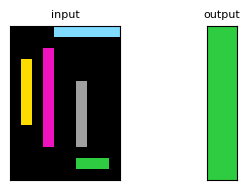

set 8


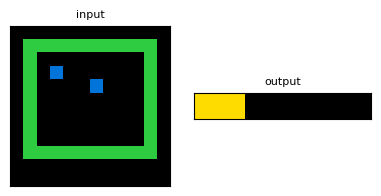

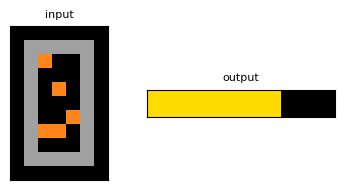

set 9


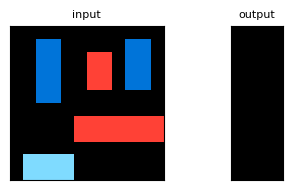

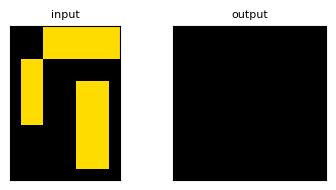

set 10


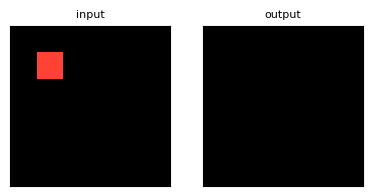

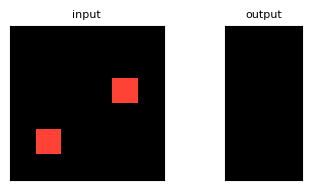

Copy
set 0


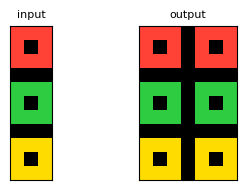

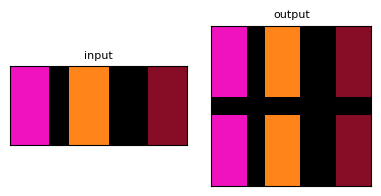

set 1


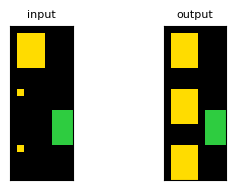

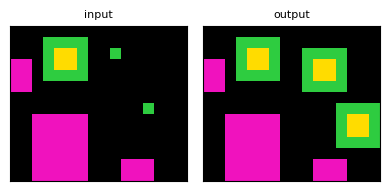

set 2


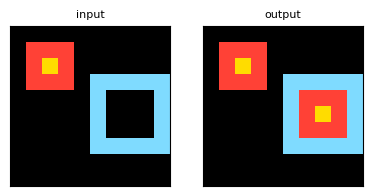

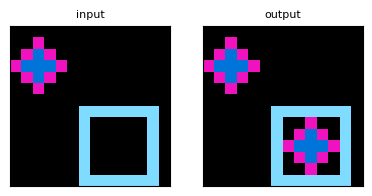

set 3


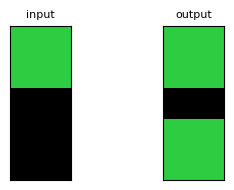

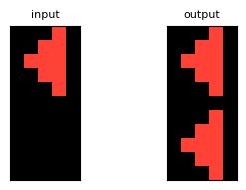

set 4


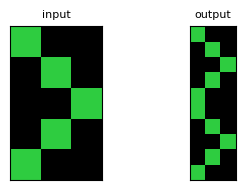

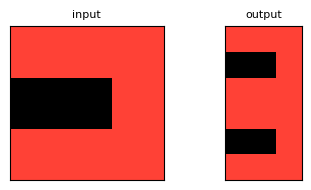

set 5


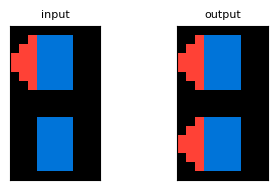

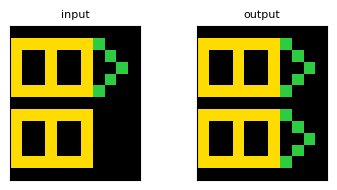

set 6


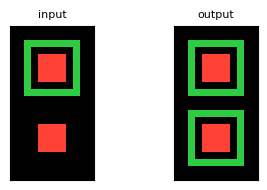

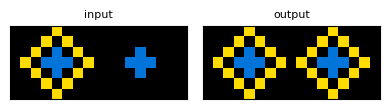

set 7


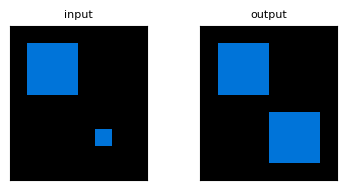

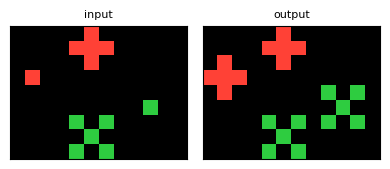

set 8


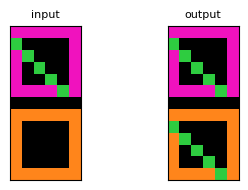

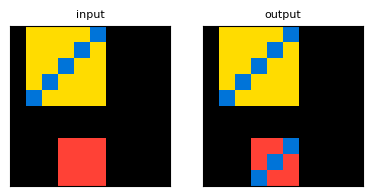

set 9


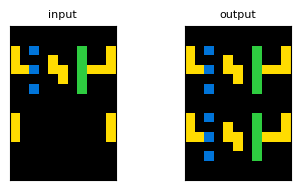

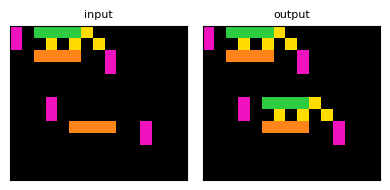

set 10


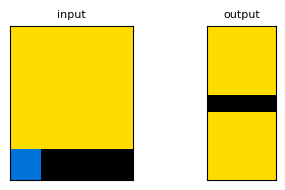

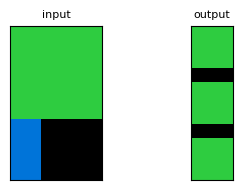

ExtractObjects
set 0


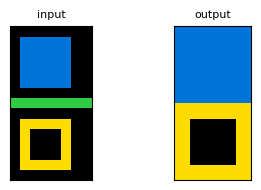

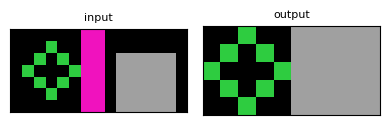

set 1


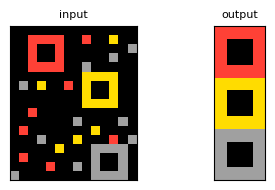

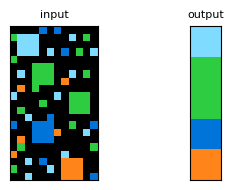

set 2


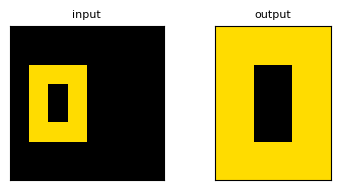

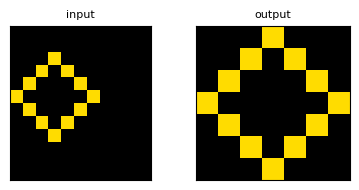

set 3


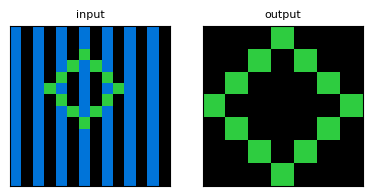

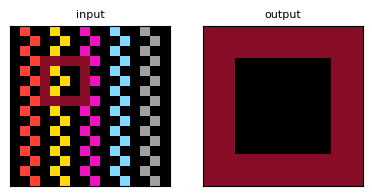

set 4


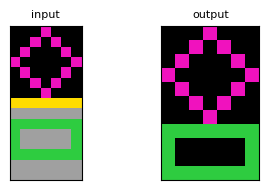

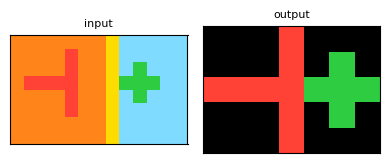

set 5


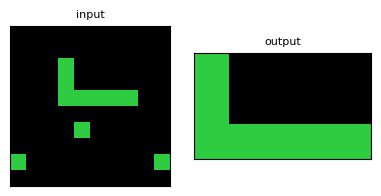

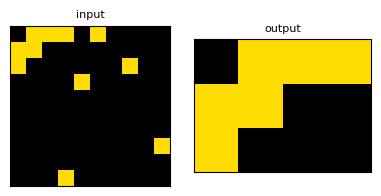

set 6


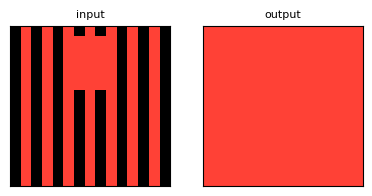

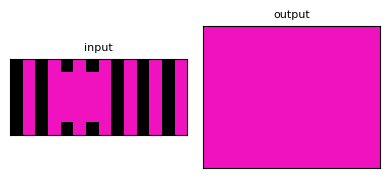

set 7


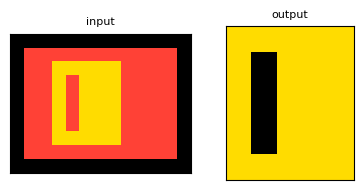

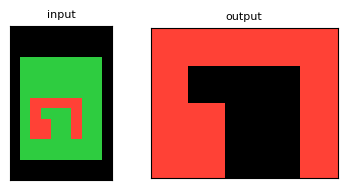

set 8


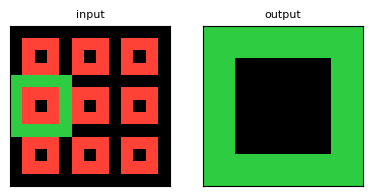

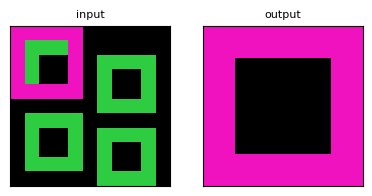

set 9


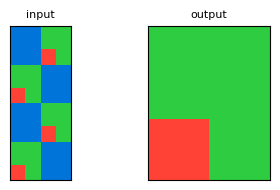

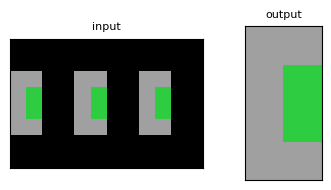

set 10


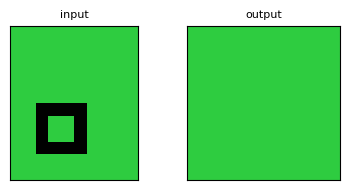

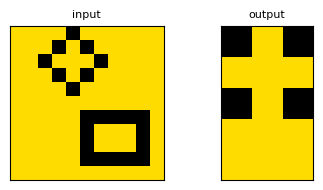

ExtendToBoundary
set 0


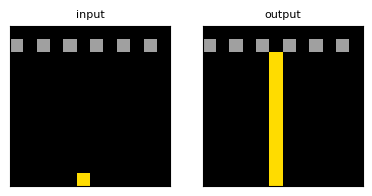

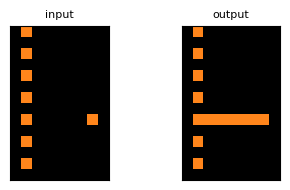

set 1


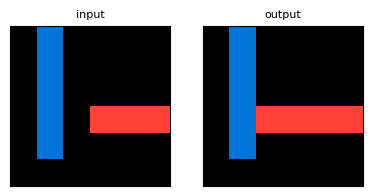

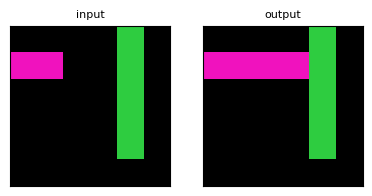

set 2


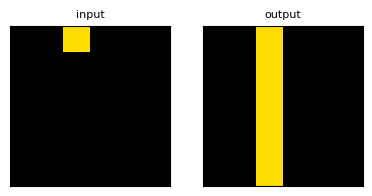

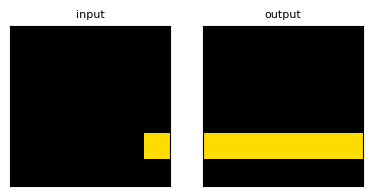

set 3


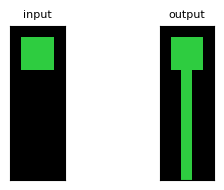

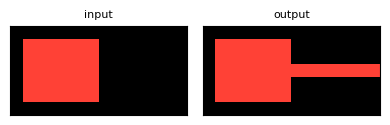

set 4


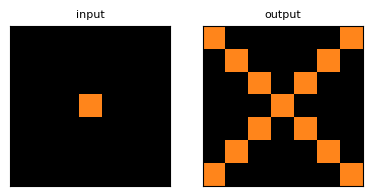

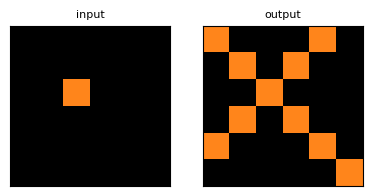

set 5


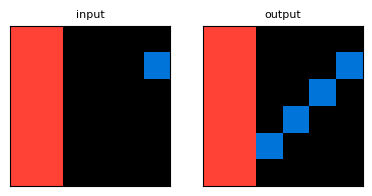

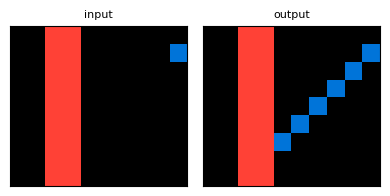

set 6


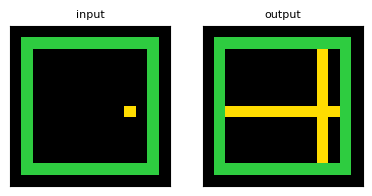

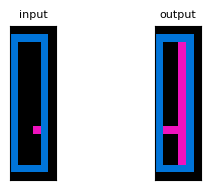

set 7


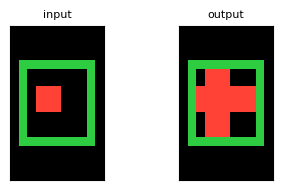

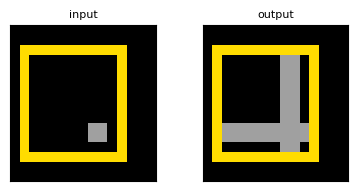

set 8


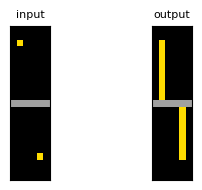

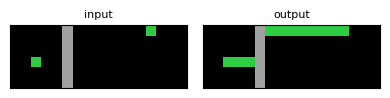

set 9


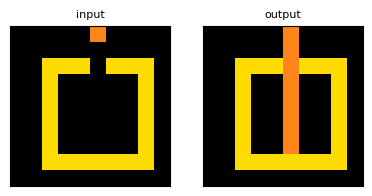

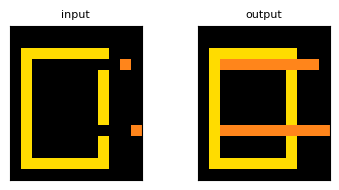

set 10


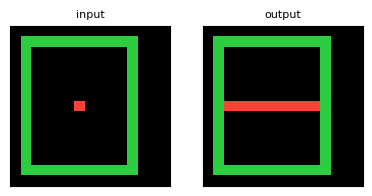

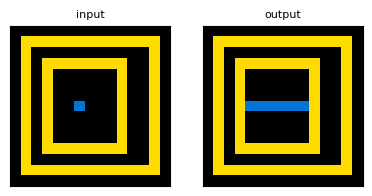

Order
set 0


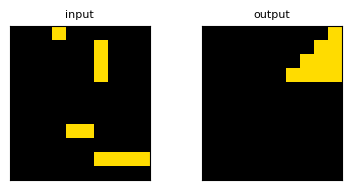

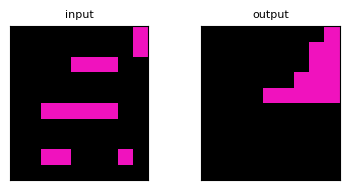

set 1


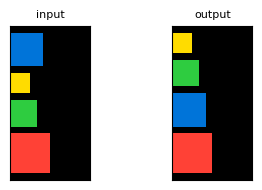

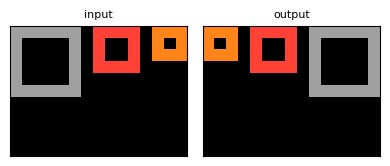

set 2


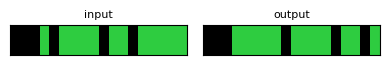

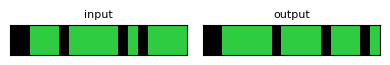

set 3


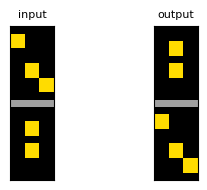

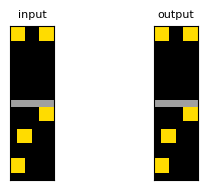

set 4


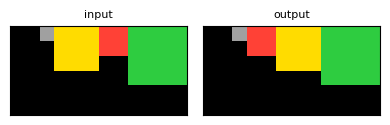

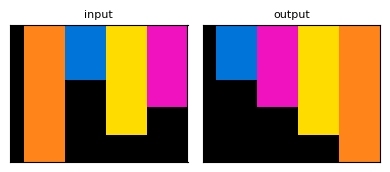

set 5


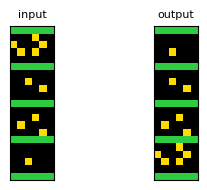

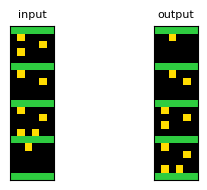

set 6


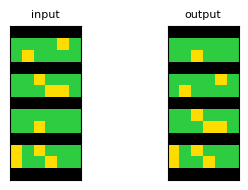

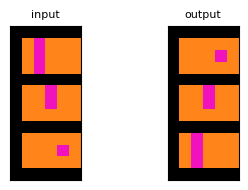

set 7


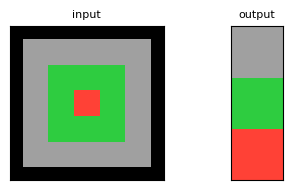

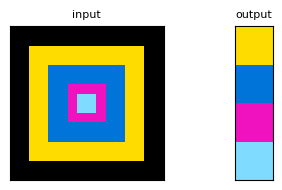

set 8


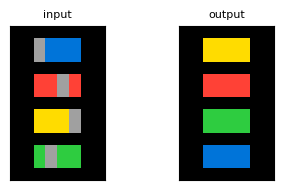

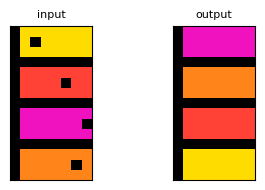

set 9


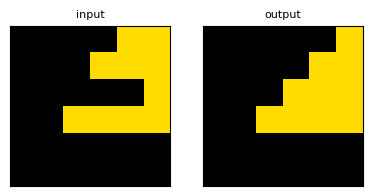

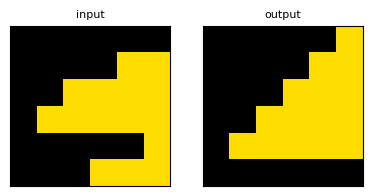

set 10


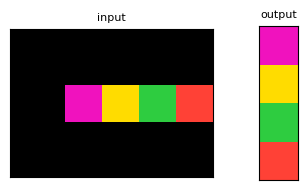

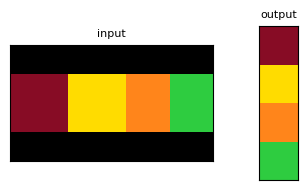

CompleteShape
set 0


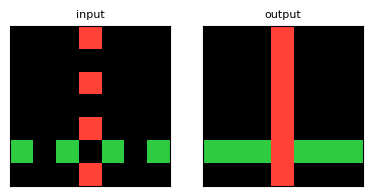

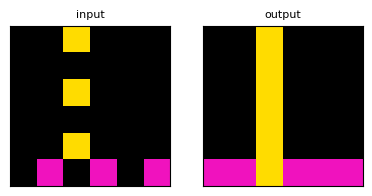

set 1


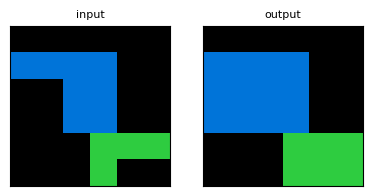

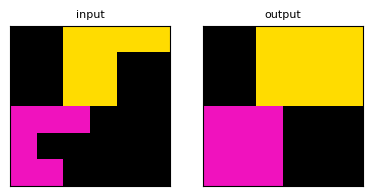

set 2


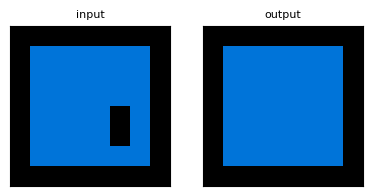

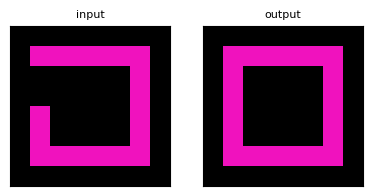

set 3


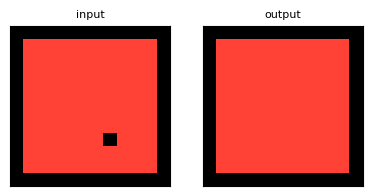

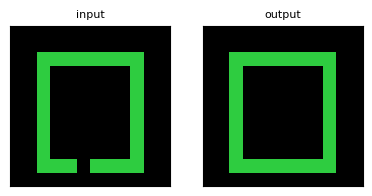

set 4


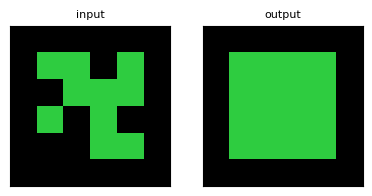

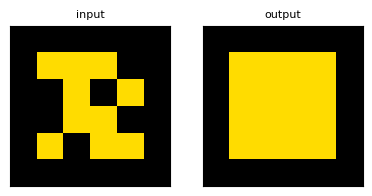

set 5


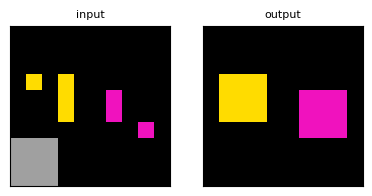

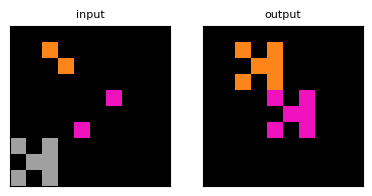

set 6


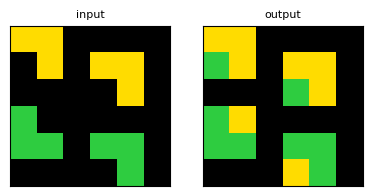

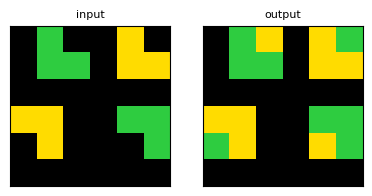

set 7


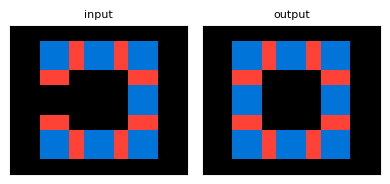

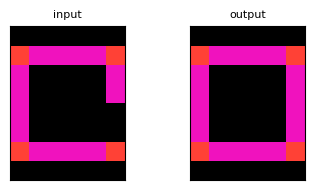

set 8


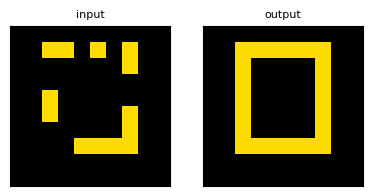

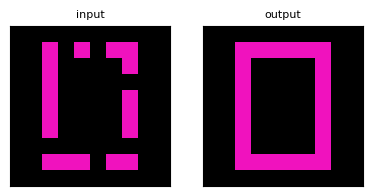

set 9


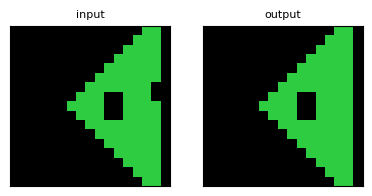

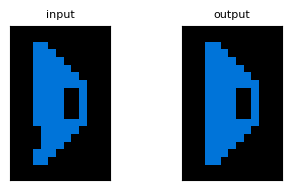

set 10


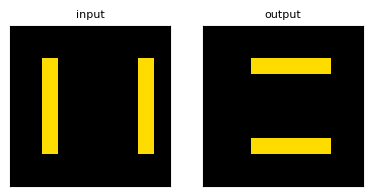

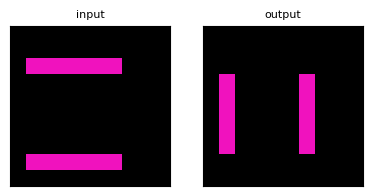

Center
set 0


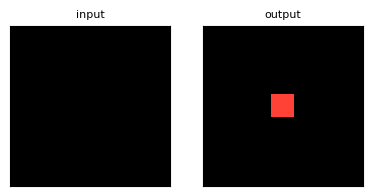

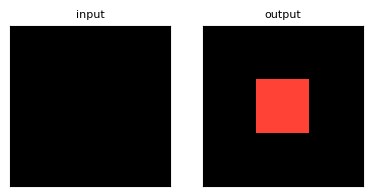

set 1


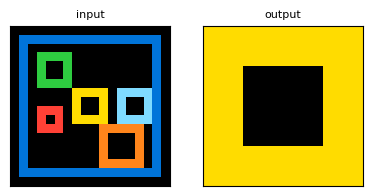

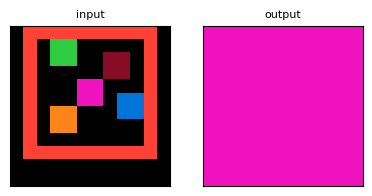

set 2


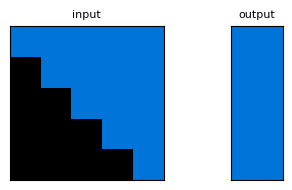

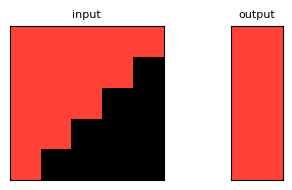

set 3


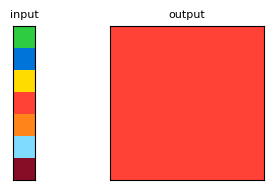

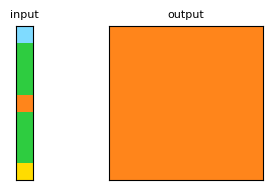

set 4


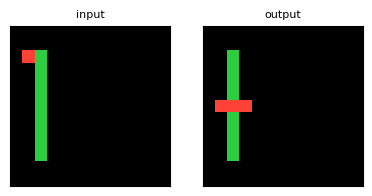

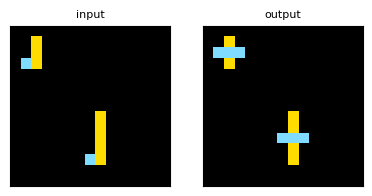

set 5


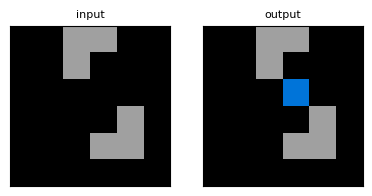

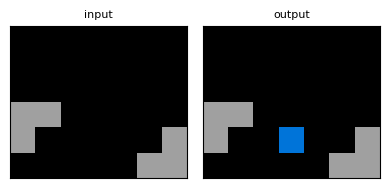

set 6


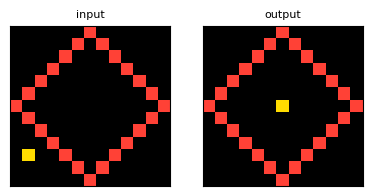

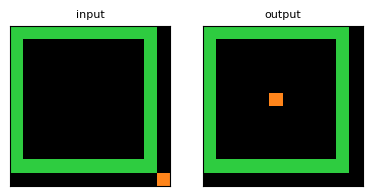

set 7


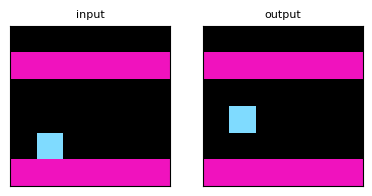

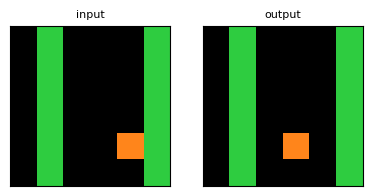

set 8


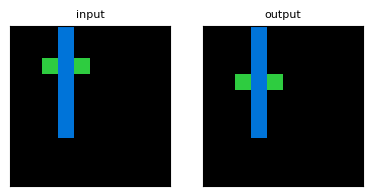

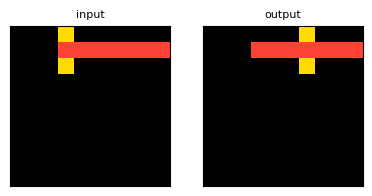

set 9


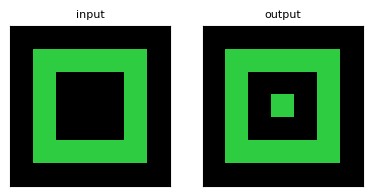

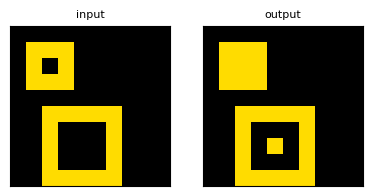

set 10


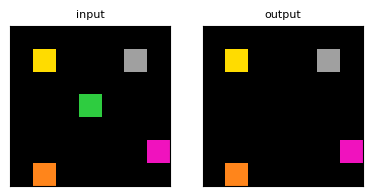

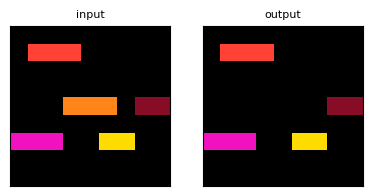

FilledNotFilled
set 0


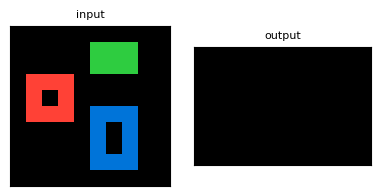

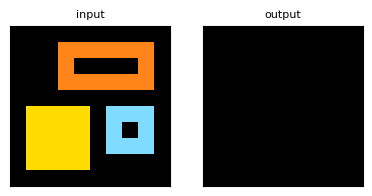

set 1


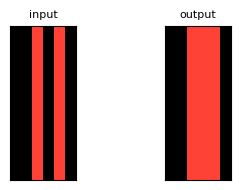

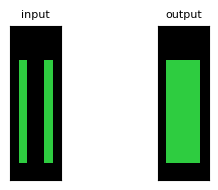

set 2


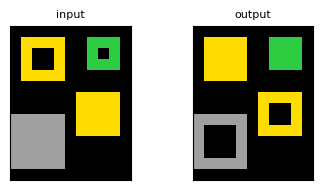

IndexError: list index out of range

In [37]:
# Loop over all the concepts
for k in range(len(problems)+1):
    
    print(problems[k][0])
    # Pairs of all input output, train test, example 0

    for j in range(len(problems[k][1:])):
        print(f"set {j}")
        z = problems[k][1:][j]

        for n in range(len(z)):
            data = z["train"][n]

            transformed_data = [
                [
                    np.array(data['input']),
                    np.array(data['output'])
                ]
            ]
            plot_arc_input_outputs(transformed_data)